In [ ]:
#|default_exp callback.utils

# Callback Utilities
> Additional functionality for fastai callbacks

In [ ]:
#|export
from __future__ import annotations

from fastai.basics import defaults
from fastai.callback.core import Callback
from fastai.callback.schedule import SchedCos, _Annealer
from fastai.learner import Learner, Recorder

try:
    import wandb
    from fastai.callback.wandb import WandbCallback
    WANDB = True
except ImportError:
    WANDB = False

try:
    import tensorboard
    from fastai.callback.tensorboard import TensorBoardCallback
    TENSORBOARD = True
except ImportError:
    TENSORBOARD = False

from fastxtend.imports import *

In [ ]:
#|hide
from nbdev.showdoc import show_doc

## Log Values From Callbacks

fastxtend adds the ability to log additional values from callbacks via `LogDispatch` callback and `Learner._log_values` & `Learner._log_dict`.

To log additional values to a supported logger, import <code>LogDispatch</code> and then pass values as arguments to `self.learn._log_values` or as a dictionary to `self.learn._log_dict` in `after_batch` for training values and `after_epoch` for validation values.

```python
from fastxtend.callback.utils import *

def ExampleCallback(Callback)
    def after_batch(self):
        self.learn._log_values(train_value1=value1, train_value2=value2)

    def after_epoch(self):
        self.learn._log_dict({'valid/value1':value1, 'valid/value2':value2})
```

<code>LogDispatch</code> will update a train and valid dictionary using the argument names as keys, and will call each supported logger's update method after `Recorder` runs.

If imported <code>LogDispatch</code> will automatically be added to the default fastai callbacks.

Supported loggers:

* `fastai.callback.wandb.WandbCallback`
* `fastai.callback.tensorboard.TensorBoardCallback`

fastxtend uses <code>LogDispatch</code> across multiple callbacks, such as `EMAWarmupCallback` and `ProgressiveResize`, to log additional information.

PRs to add additional supported loggers are welcome.

### Weights and Biases Features

`LogDispatch.log_wandb_table` allows logging a [Weights and Biases Table](https://docs.wandb.ai/guides/track/log/log-tables) in a callback.

```python
def ExampleCallback(Callback)
    def after_fit(self):
        self.learn.log_dispatch.log_wandb_table(name='pandas_df', dataframe=pandas_df)
```

`LogDispatch.log_wandb_summary` allows logging [Weights and Biases Summary Metrics](https://docs.wandb.ai/guides/track/log/log-summary) in a callback.

```python
def ExampleCallback(Callback)
    def after_fit(self):
        self.learn.log_dispatch.log_wandb_summary(name='summary_metric', summary=summary_metric)
```

In [ ]:
#|export
# key should be the fastai callback name
available_loggers = {
    'wandb': WANDB,
    'tensorboard': TENSORBOARD
    }

In [ ]:
#|export
class LogDispatch(Callback):
    "A default callback for dispatching additional values to loggers"
    run_valid, order = False, Recorder.order+2
    remove_on_fetch = True

    def before_fit(self):
        "Log additional values if a supported logger is detected"
        self.train_values, self.valid_values = {}, {}
        self.loggers = []
        for logger, available in available_loggers.items():
            if available and hasattr(self.learn, logger):
                self.loggers.append(getattr(self, f'_log_{logger}'))
        # only run if there are initialize loggers
        self.run = len(self.loggers) > 0

    def after_batch(self):
        "Logs training values added by `_update_values` via `Learner.update_logger_values`"
        if self.learn.recorder.run_train and len(self.train_values) > 0:
            for log in self.loggers:
                log(self.train_values)

    def after_epoch(self):
        "Logs valid values added by `_update_values` via `Learner.update_logger_values`"
        if len(self.valid_values) > 0:
            for log in self.loggers:
                log(self.valid_values)

    def log_wandb_table(self, name:str, **kwargs):
        "Log `wandb.Table` to Weights and Biases. See `wandb.Table` for details"
        if WANDB:
            wandb.log({name: wandb.Table(**kwargs)})
        else:
            raise warn("Tried logging Weights and Biases table without wandb installed")

    def log_wandb_summary(self, name:str, summary:Callable):
        "Log Summary Metrics to Weights and Biases. See `wandb.summary` for details"
        if WANDB:
            wandb.summary[name] = summary
        else:
            raise warn("Tried logging Weights and Biases Summary Metrics without wandb installed")

    def _update_values(self, **kwargs):
        "Update log dictionaries using arguments"
        if self.training:
            self.train_values.update(**kwargs)
        else:
            self.valid_values.update(**kwargs)

    def _update_dict(self, value_dict:dict):
        "Update log dictionaries wiht a dictionary"
        if self.training:
            self.train_values.update(value_dict)
        else:
            self.valid_values.update(value_dict)

    def _log_wandb(self, values:dict):
        "Internal method to log values to Weights and Biases"
        wandb.log(values, self.learn.wandb._wandb_step)

    def _log_tensorboard(self, values:dict):
        "Internal method to log scalers to TensorBoard"
        for k,v in values.items():
            self.learn.tensorboard.writer.add_scalar(k, v, self.train_iter)

In [ ]:
show_doc(LogDispatch.log_wandb_table)

In [ ]:
show_doc(LogDispatch.log_wandb_summary)

In [ ]:
#|exporti
if LogDispatch not in defaults.callbacks:
    defaults.callbacks.append(LogDispatch)

In [ ]:
#|export
@patch
def _log_values(self:Learner, **kwargs):
    "Update additional logging values from arguments using `LogDispatch`."
    self.log_dispatch._update_values(**kwargs)

In [ ]:
show_doc(Learner._log_values)

In [ ]:
#|export
@patch
def _log_dict(self:Learner, value_dict:dict):
    "Update additional logging values from a dictionary using `LogDispatch`."
    self.log_dispatch._update_dict(value_dict)

In [ ]:
show_doc(Learner._log_dict)

## Callback Scheduler

<code>CallbackScheduler</code> is a utlitity method for callback developers to modifying callback values on a schedule.

fastxtend uses it in `EMAWarmupCallback` to schedule the EMA decay rate.

In [ ]:
#|export
class CallbackScheduler():
    "A mixin for scheduling values in a Callback"

    def setup_schedule(self,
        n_epoch:int, # Number of training epochs. From a callback pass n_epoch
        dls_len:int, # Length of the training dataset
        start_value:Numeric, # Initial scheduling value
        final_value:Numeric, # Final scheduling value
        start:Numeric, # Start schedule in percent of training steps (float) or epochs (int, index 0)
        finish:Numeric, # Finish schedule in percent of training steps (float) or epochs (int, index 0)
        schedule:Callable[..., _Annealer]=SchedCos, # Schedule type. Any fastai schedule annealer
        ndigits:Numeric|None=None, # Round return value to ndigits if set using Python's `round`.
        callback_name:str="CallbackScheduler", # Name of scheduler for warning & error messages
        resume:bool=False, # Whether training has resumed or not
    ):
        "Setup the schedule for `schedule_step`. Call during `Callback.begin_fit`"
        if start > finish:
            raise ValueError(f'{callback_name} schedule {start=} is greater then {finish=}')

        if finish >= 1 and isinstance(finish, int):
            finish = finish/n_epoch
        if finish > 1:
            warn(f'{callback_name} {finish=} is  greater than one and will not finish in this training run')

        if resume and n_epoch < finish*n_epoch:
            raise ValueError(f"Resuming {callback_name} before the schedule is finished is not supported")

        self.start = start
        self.finish = finish
        self.final_value = final_value
        self.ndigits = ndigits
        self.schedule_pct = 0.
        self.schedule = schedule(start_value, final_value)
        self._schedule_sched = 1/(dls_len * n_epoch * (finish - start))

    def schedule_step(self,
        value:Numeric, # Value to schedule. Value is returned as the passed in type
        pct_train:float # Training progress in percent. From a callback pass self.pct_train
    ):
        "Takes a scheduling step and returns updated value"
        value_type = type(value)
        if pct_train >= self.start and value != self.final_value:
            if pct_train >= self.finish:
                value = self.final_value
            else:
                value = self.schedule(self.schedule_pct)
                self.schedule_pct += self._schedule_sched
        if self.ndigits is not None:
            return value_type(round(value, self.ndigits))
        else:
            return value_type(value)

In [ ]:
show_doc(CallbackScheduler)

In [ ]:
show_doc(CallbackScheduler.setup_schedule)

In [ ]:
show_doc(CallbackScheduler.schedule_step)

## Tests -

In [ ]:
#|hide
import matplotlib.pyplot as plt

from fastxtend.test_utils import *

In [ ]:
#|hide
class UtilsTest(Callback, CallbackScheduler):
    "Test LogDispatch & CallbackScheduler"
    def __init__(self, **kwargs):
        CallbackScheduler.__init__(self)

    def before_fit(self):
        self.value = 0.
        self.values, self.epochs = [], []
        super().setup_schedule(self.n_epoch, len(self.dls.train), 0,
                               0.9, 0.25, 0.75, callback_name='CallbackSchedulerTest')

    def before_batch(self):
        self.value = super().schedule_step(self.value, self.pct_train)

    def after_batch(self):
        assert self.learn.log_dispatch.run == False
        self.learn._log_values(value=self.value)
        self.values.append(self.value)

    def after_fit(self):
        plt.figure(figsize=(4,4))
        plt.plot(self.values)
        plt.ylim(0,1)
        plt.xlabel('Training Percent')
        plt.ylabel('Schedule Value')
        assert self.learn.log_dispatch.train_values.get('value', 0) == 0.9

epoch,train_loss,valid_loss,time
0,6.998855,6.030475,00:00


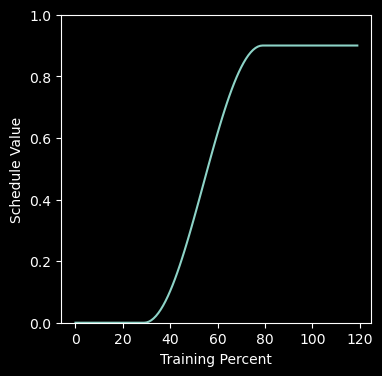

In [ ]:
#|hide
with no_random():
    learn = synth_learner(cbs=[UtilsTest])
    learn.fit(10, 1e-3)